# Using Age, Cholestorol Levels, and Blood Pressure to assess prognosis of heart disease.

Ethan D'Souza, Emily Zhang, Alice An, Vivann Wadhwa

# 1. Introduction

Heart disease is a common cause of death between all groups of people in the United States. Both genetic and environmental circumstances can contribute to the possibility of developing the condition. 

Multiple risk factors affect the likelihood of heart disease such as age, blood pressure, cholesterol. Older people are more likely to be diagnosed with heart disease (Rogers et al., 2019). According to the CDC, high cholesterol levels lead to plaque formation in blood vessels which makes them less flexible and narrower. Leading to the inability of blood to circulate around the body, irregular heart beats and ultimately, death. Furthermore, high blood pressure causes arteries to lose their elasticity which in turn leads to lower blood circulation to the heart.

Ultimately, our goal is to answer the question "Can age, resting blood pressure, and cholesterol accurately predict heart disease?"

# 2. Preliminary Data Analysis

For starters, we load the necessary packages needed to perform the analysis. 

In [2]:
library(repr)
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

The data is first loaded from the web. We tidied the data, and renamed the columns for better readability. We ended up with a final tibble containing the four variables that are relevant to our question. Here, likelihood is our classification variable with type “factor”, and age, resting blood pressure, and cholesterol are predictor variables all with type “double”. 

In [3]:
raw_data_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
raw_data <- read_csv(raw_data_url,col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs","restecg", "thalach", "exang" ,"oldpeak" ,"slope" ,"ca" ,"thal" ,"num"))
tidy_data <- raw_data |>
                select(age,trestbps,chol,num) |>
                    rename("age" = "age",
                           "resting.blood.pressure" = "trestbps" ,
                           "cholesterol" = "chol",
                           "heart.disease" = "num") |>
                    mutate(heart.disease = case_when(heart.disease == 0 ~ "Absent",
                                                  heart.disease != 0 ~ "Present")) |>
                    mutate(heart.disease = as.factor(heart.disease))
head(tidy_data)
                

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,resting.blood.pressure,cholesterol,heart.disease
<dbl>,<dbl>,<dbl>,<fct>
63,145,233,Absent
67,160,286,Present
67,120,229,Present
37,130,250,Absent
41,130,204,Absent
56,120,236,Absent


We set the seed so that all the code below is reproducible. The data is then split into 75% training data, and 25% testing data. Only the training data will be used in our analysis. 

In [4]:
set.seed(1) ## DO NOT CHANGE

## splitting into training and testing data
data_split <- initial_split(tidy_data, prop = 0.75, strata = heart.disease)
data_train <- training(data_split)
data_test <- testing(data_split)

The data is summarized into two tables: 
- number of observations of “present” and "absent"
- average values of all predictors for observations for "absent" and "present"


In [5]:
##Number of observations of "absent" and "present"
data_count <- data_train |> 
        group_by(heart.disease) |>
        summarize(count = n())
data_count

heart.disease,count
<fct>,<int>
Absent,123
Present,104


In [6]:
##Average Values of all predictors for "absent" and "present"

data_mean <- data_train |>
        group_by(heart.disease) |>
        summarize(across(age:cholesterol, mean)) |>
         rename("mean.age" = "age",
                           "mean.resting.blood.pressure" = "resting.blood.pressure" ,
                           "mean.cholesterol" = "cholesterol") 

data_mean

heart.disease,mean.age,mean.resting.blood.pressure,mean.cholesterol
<fct>,<dbl>,<dbl>,<dbl>
Absent,52.96748,130.4553,243.9106
Present,57.23077,135.5096,250.5673


## Visualizations

Created a scatterplot of Resting Blood Pressure in mm of Mercury(Hg) against Age of the patient, coloured by likelihood. After age 50 there seems to be more individuals with heart disease present than without and the average Resting Blood Pressure increases.  

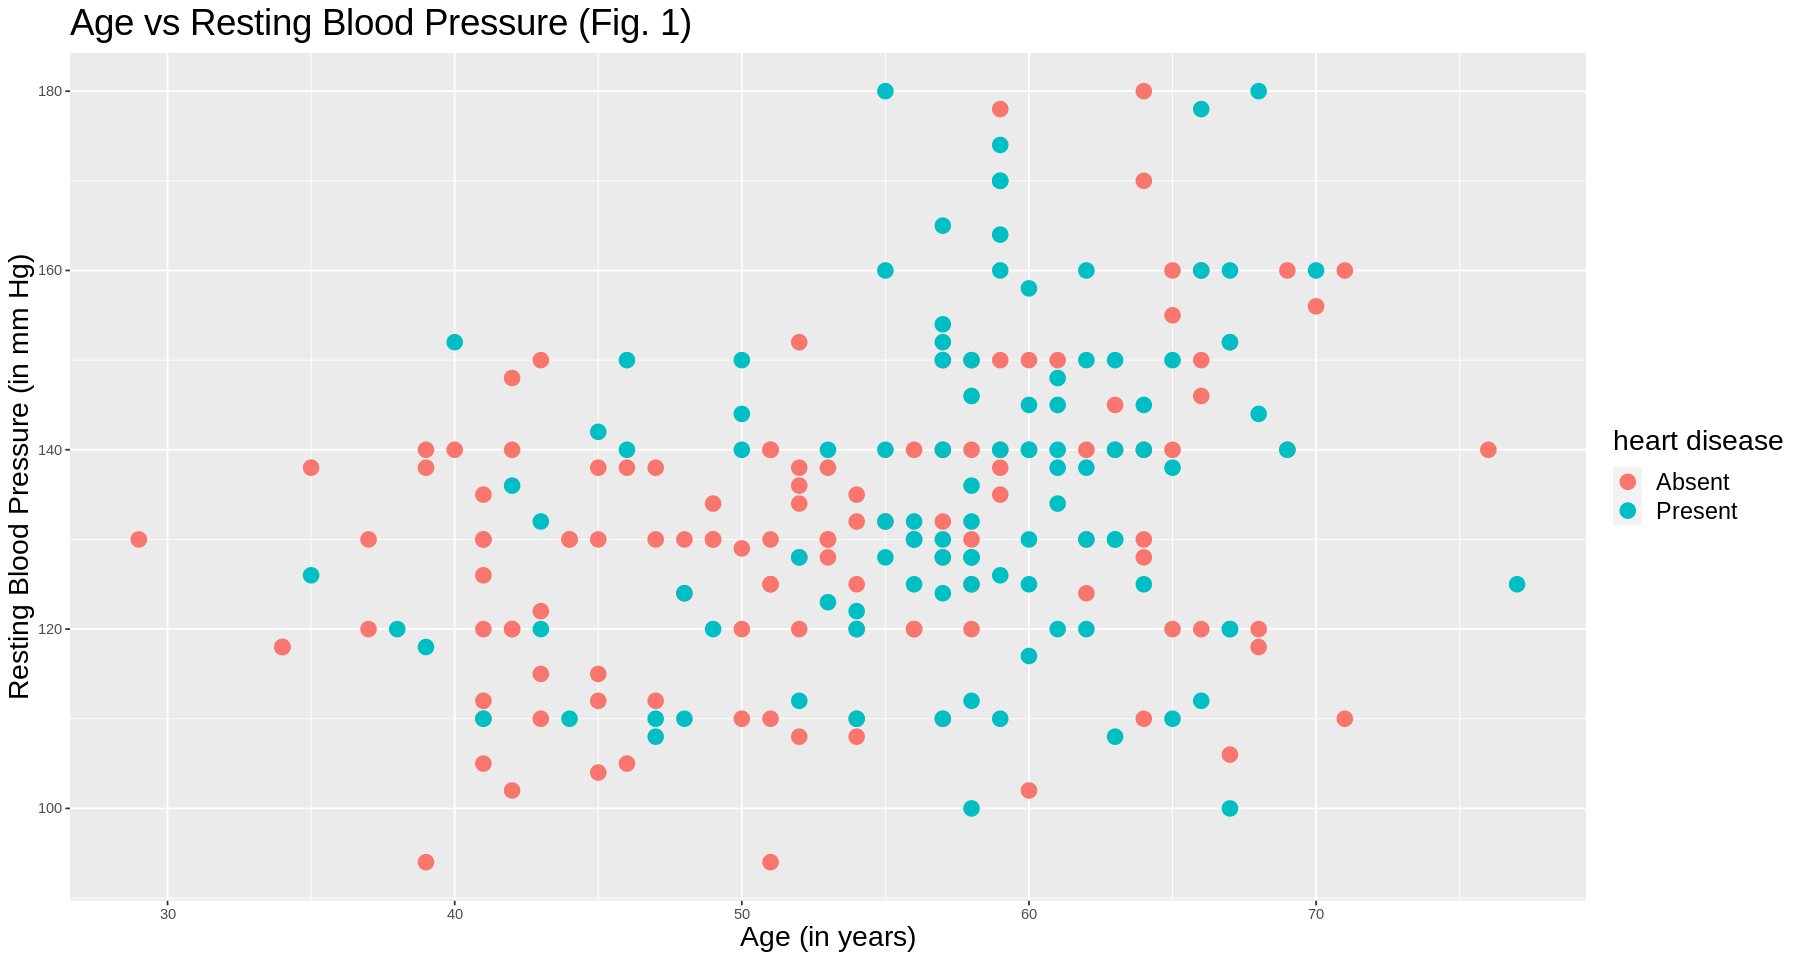

In [7]:
##Age vs Blood Pressure, coloured by likelihood

options(repr.plot.width=15, repr.plot.height=8)
age_v_bp_plot <- data_train |>
                ggplot(aes(x = age, y = resting.blood.pressure, color = heart.disease)) +
                geom_point(size = 4) +
                xlab("Age (in years)") +
                ylab("Resting Blood Pressure (in mm Hg)") +
                labs(color = "heart disease", shape = "liki") +
                ggtitle("Age vs Resting Blood Pressure (Fig. 1)") + 
                theme(plot.title = element_text(size=22),
                      axis.title = element_text(size=17),
                      legend.title = element_text(size = 17),
                      legend.text = element_text(size = 14))

age_v_bp_plot

Created a scatterplot of Cholesterol Level in mg/dl against Age of the patient, coloured by likelihood. Cholesterol level seems to increase on average as age increases, and above the age of 50, the presence of heart disease increases significantly.

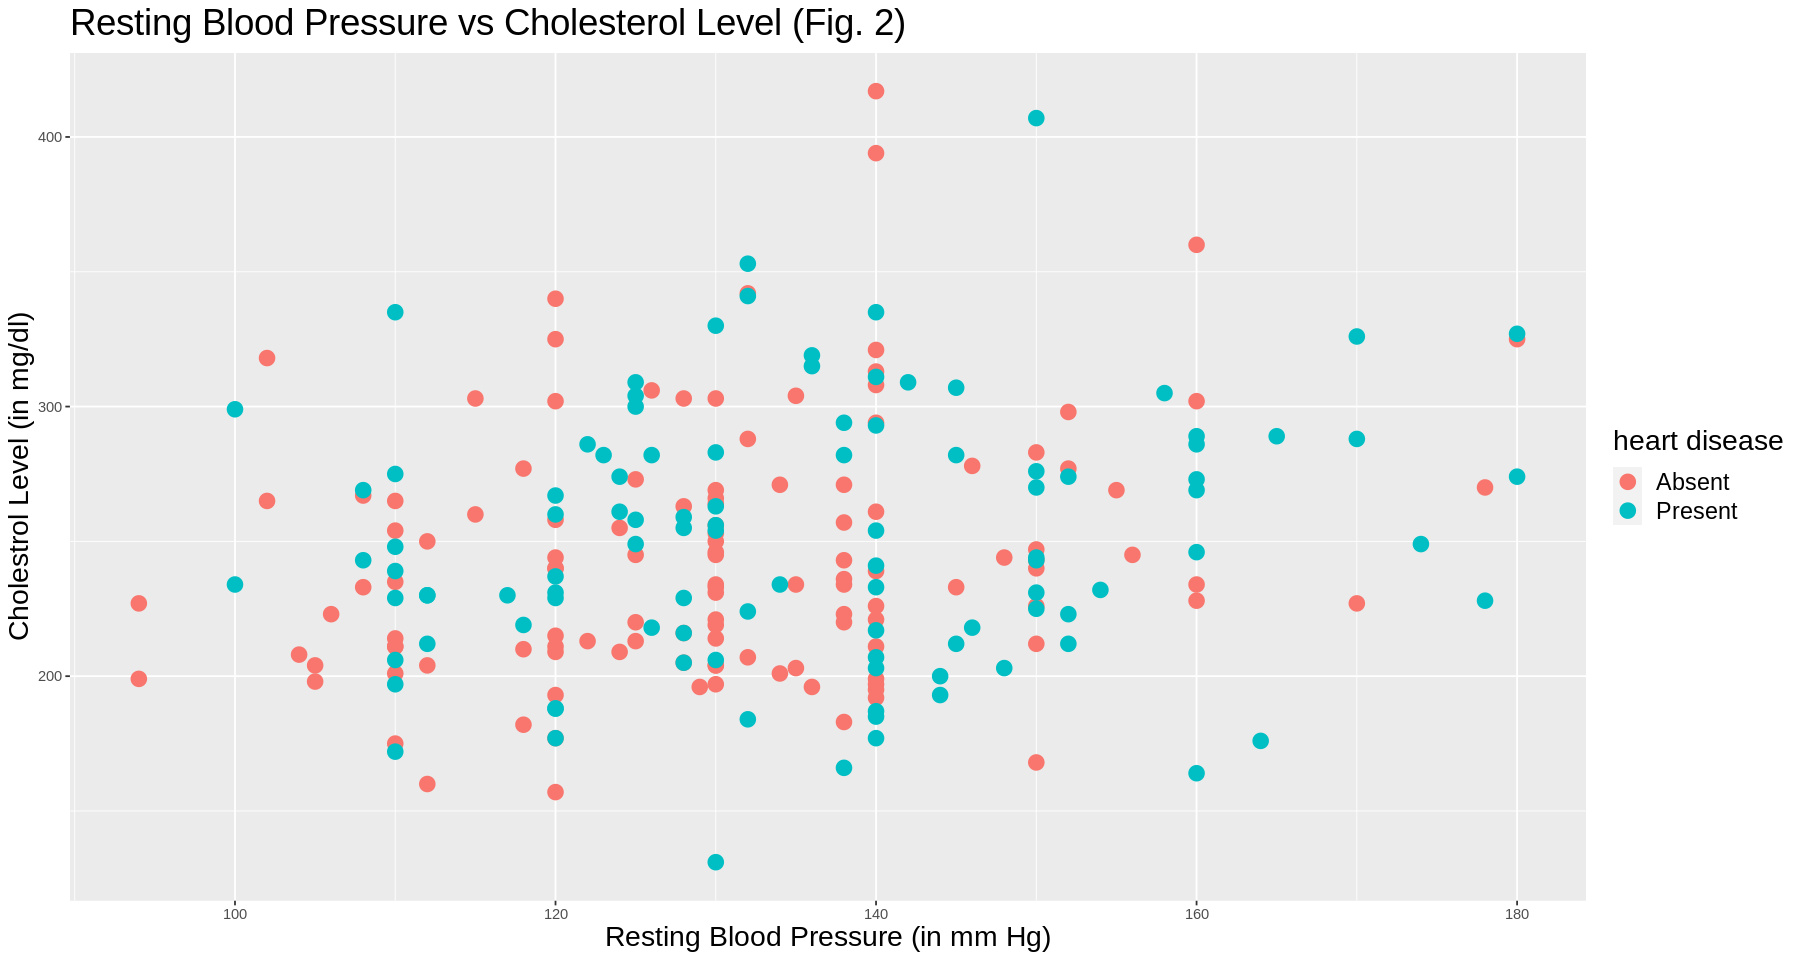

In [12]:
##blood pressure vs Cholestrol Level, coloured by likelihood

bp_v_chol_plot <- data_train |>
                ggplot(aes(x = resting.blood.pressure, y = cholesterol, color = heart.disease)) +
                geom_point(size = 4) +
                xlab("Resting Blood Pressure (in mm Hg)") +
                ylab("Cholestrol Level (in mg/dl)") +
                labs(color = "heart disease") +
                ggtitle("Resting Blood Pressure vs Cholesterol Level (Fig. 2)") + 
                theme(plot.title = element_text(size=22),
                     axis.title = element_text(size=17),
                     legend.title = element_text(size = 17),
                     legend.text = element_text(size = 14))

bp_v_chol_plot

Below is a scatterplot illustrating the relationship between cholestrol level and blood pressure, and whether or not that affects the presence/absence of heart disease. From the graph, we saw no relationship as there was an even distribution of points between the cholesterol and blood pressure. 


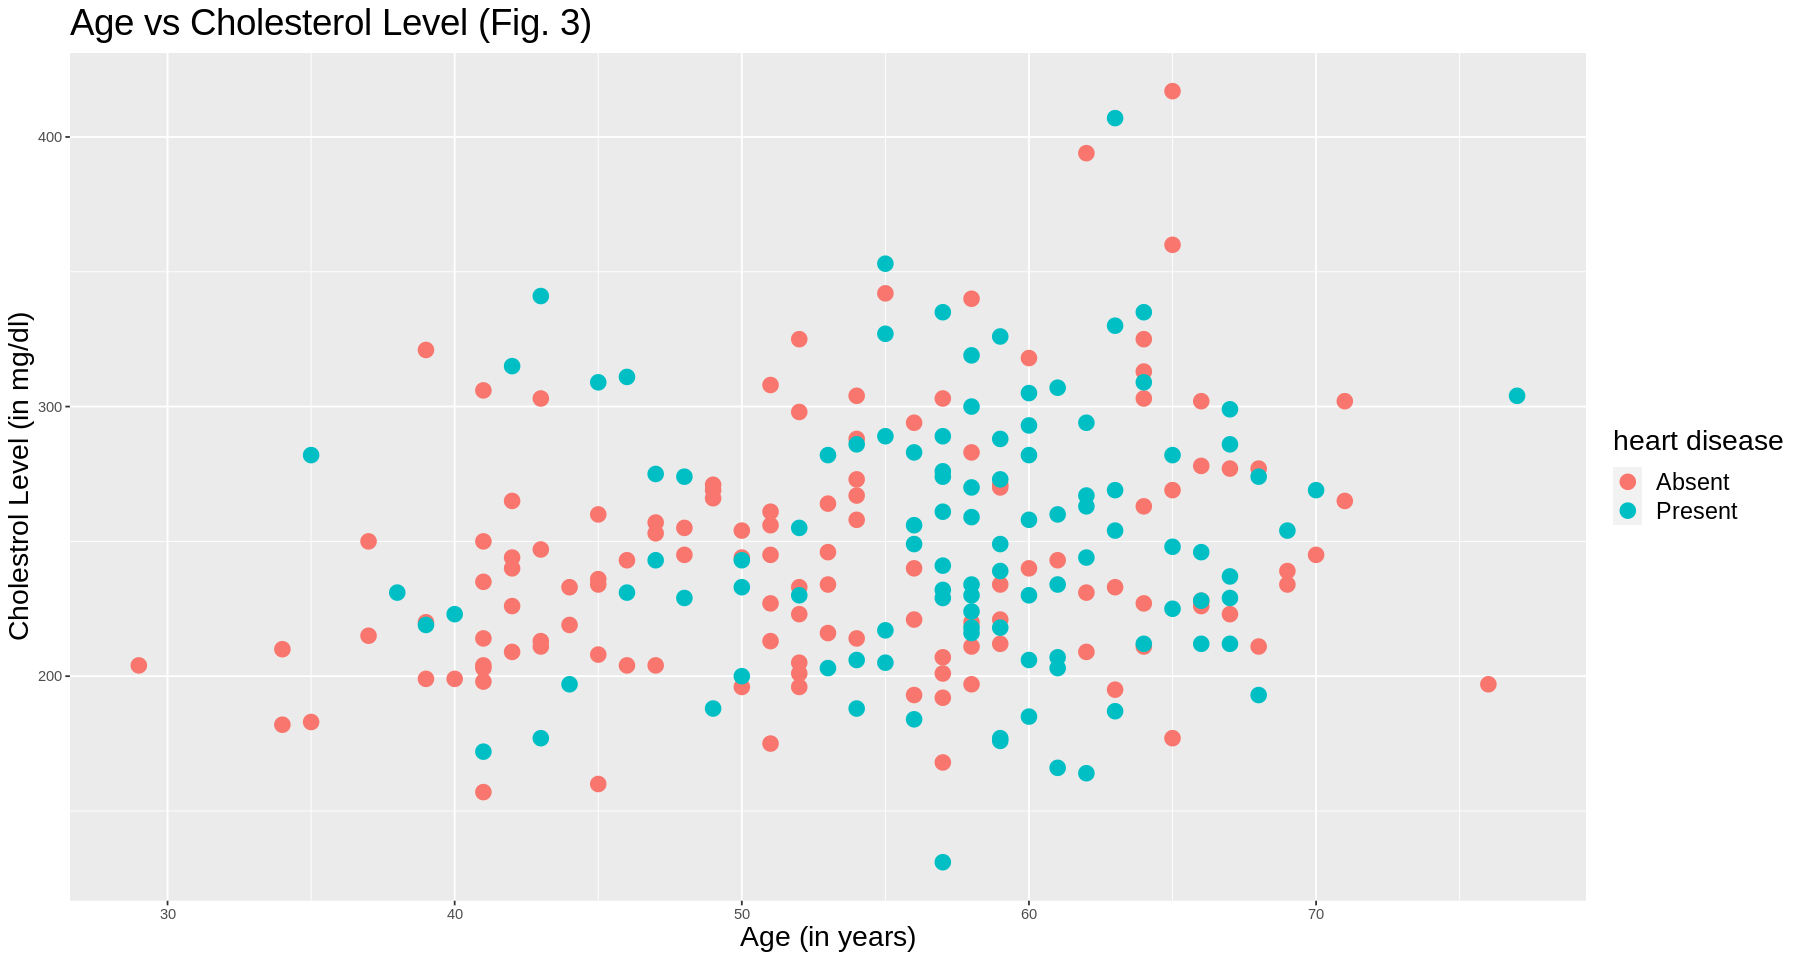

In [14]:
##Age vs Cholestrol Level, coloured by likelihood

age_v_chol_plot <- data_train |>
                ggplot(aes(x = age, y = cholesterol, color = heart.disease)) +
                geom_point(size = 4) +
                xlab("Age (in years)") +
                ylab("Cholestrol Level (in mg/dl)") +
                labs(color = "heart disease") +
                ggtitle("Age vs Cholesterol Level (Fig. 3)") + 
                theme(plot.title = element_text(size=22),
                     axis.title = element_text(size=17),
                     legend.title = element_text(size = 17),
                     legend.text = element_text(size = 14))

age_v_chol_plot


# 3. Methods

Using the Heart Disease dataset provided to us from the UCI Machine Learning Repository, we will use 4 of the variables provided.  They are as follows: age, blood pressure, cholesterol,  and diagnosis of heart disease. From those four variables, we use 3 predictors to see whether or not each data point can be classified as <50% diameter narrowing, which means no risk of heart diseases, or >50% diameter narrowing, which would indicate a severe risk of heart disease. After tidying our data, we will make graphs and colour them based on the two classes(<50% diameter narrowing or >50% diameter narrowing). The raw data consisted of 4 different values. 0 represented an absence of heart disease, and the values 1 2, 3, and 4 represented the presence of heart disease. To create a tidy dataset we mutated 0 to be "Absent" and values between 1-4 to be "Present". Then, when we receive the new data point to classify, we will plot it against the data already present and evaluate the risk of heart disease using the K-nearest neighbors method. 

To help illustrate our observations, we will use scatterplots. In order to ensure that what we are visualizing is clear, we will use markdown cells to describe and clarify.

# 4. Expected Outcomes and Significance 
We expect to find that those with higher cholestrol, high blood pressure and higher age will be at a much higher risk of heart disease than those with the opposite. 

Using these findings, we can encourage people to maintain a healthy lifestyle to preemptively prevent cardiovascular disease. 

In the future, the question that could arise is the proportion to which the genetics and environmental factors have an effect on the probability of getting the disease. 

# 5. Citations

- Centers for Disease Control and Prevention. (2022, September 8). Heart disease and stroke. Centers for Disease Control and Prevention. Retrieved March 2, 2023, from https://www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm 
- Centers for Disease Control and Prevention. (2021, May 18). High blood pressure symptoms and causes. Centers for Disease Control and Prevention. Retrieved March 2, 2023, from https://www.cdc.gov/bloodpressure/about.htm#:~:text=High%20blood%20pressure%20can%20damage%20your%20arteries%20by%20making%20them,Chest%20pain%2C%20also%20called%20angina 